In [42]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Loading the data

In [43]:
def load_pickle(file):
    objects = []
    with open(file, "rb") as openfile:
        u = pickle._Unpickler(openfile)
        u.encoding = 'latin1'
        df = u.load()
    return df

In [44]:
wthr_df = load_pickle("griddata_gfs_us_20180101_20190826_03_final.p")

In [45]:
wthr_df.head(20)

,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_%,r_pl950_%,shtfl_sfc_wm2,...,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00+00:00,0.0,16.777032,1349.927656,99212.06250,0.559356,0.005105,0.004852,89.975,83.075,-58.444885,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 07:00:00+00:00,0.0,16.606744,1352.623506,99259.81250,0.528755,0.005005,0.004739,89.250,82.250,-59.127808,...,59.839207,62.809819,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353
2018-01-01 08:00:00+00:00,0.0,16.750567,1385.881213,99340.01250,0.519516,0.004875,0.004601,88.350,81.475,-60.174194,...,66.846392,69.702886,73.395684,17.187174,10.191553,17.103298,22.151705,2018-01-01 00:00:00+00:00,134.513901,3.528108
2018-01-01 09:00:00+00:00,30.0,16.653720,1406.317913,99435.68750,0.462775,0.004693,0.004395,85.400,78.575,-61.376221,...,69.538877,72.116654,75.992542,16.804585,10.074198,16.507619,21.857454,2018-01-01 00:00:00+00:00,146.969666,9.473817
2018-01-01 10:00:00+00:00,70.0,16.143047,1413.328074,99523.67500,0.395166,0.004618,0.004322,85.275,78.300,-50.711792,...,67.391618,69.753380,73.848494,15.970588,9.719457,15.561127,21.082533,2018-01-01 00:00:00+00:00,160.319397,13.648098
2018-01-01 11:00:00+00:00,112.5,15.583189,1438.093975,99586.78750,0.235320,0.004583,0.004280,85.825,78.725,-32.249207,...,63.858062,65.832971,69.562204,15.492419,9.677084,15.105547,20.183641,2018-01-01 00:00:00+00:00,174.349304,15.712183
2018-01-01 12:00:00+00:00,97.5,15.498557,1464.667720,99657.97500,0.202019,0.004578,0.004282,86.450,79.225,-24.127075,...,60.963441,63.024267,67.200959,14.916884,9.337325,14.561644,19.715329,2018-01-01 06:00:00+00:00,189.105545,15.421640
2018-01-01 13:00:00+00:00,80.0,15.042017,1429.919229,99670.55625,0.269230,0.004615,0.004330,86.800,79.700,-27.122162,...,57.890076,60.216992,64.969857,14.378203,8.790862,14.000813,19.143117,2018-01-01 06:00:00+00:00,203.006714,12.824689
2018-01-01 14:00:00+00:00,60.0,14.252443,1307.314507,99673.75000,0.433360,0.004663,0.004401,87.400,80.325,-35.922699,...,53.987252,56.570893,62.029857,13.852502,8.198470,13.453822,18.630961,2018-01-01 06:00:00+00:00,216.151535,8.189642


In [46]:
nrg_df = load_pickle("obs_20180101_20190625_03_final_normed.p")

## Merging the two data frames.

In [47]:
nrg_df['date_by_hour'] = 'NaN'
for i, row in nrg_df.iterrows(): #i is the timestamp index
    nrg_df.date_by_hour[i] = pd.datetime(i.year, 
                                      i.month, 
                                      i.day, 
                                      i.hour, 
                                      tzinfo = i.tzinfo)

C:\Users\thoma\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\thoma\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [48]:
#mrgd_df = pd.concat([nrg_df.set_index('date_by_hour'), wthr_df], axis=1, join='inner')
def increment_wthr_ts(iterator):
    j, wrow = next(iterator)
    return pd.Timestamp(j), wrow

dummy_lst = [[np.nan]*26] * nrg_df.shape[0]
wthr_iterator = wthr_df.iterrows()
ts_wthr, wrow = increment_wthr_ts(wthr_iterator)

for ind, (i, row) in enumerate(nrg_df.iterrows()):
    ts_nrg = pd.Timestamp(row.date_by_hour)
    if ts_nrg > ts_wthr:
        ts_wthr, wrow = increment_wthr_ts(wthr_iterator)
    if ts_nrg == ts_wthr:
        dummy_lst[ind] = [itm for itm in wrow]

In [49]:
nrg_df.index = nrg_df.index.tz_convert(None)

In [50]:
mrg_df = pd.concat([nrg_df, pd.DataFrame(dummy_lst, index = nrg_df.index, columns = wthr_df.columns)],axis=1)

In [51]:
clean_df = mrg_df[mrg_df.azimuth.isnull() == False].copy()

In [52]:
clean_df.head()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-01 06:00:00,0.561235,0.933616,0.372381,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:10:00,0.512618,0.958089,0.445471,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:20:00,0.494356,0.966840,0.472484,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:30:00,0.484470,0.970603,0.486133,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:40:00,0.509116,0.983485,0.474370,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894


In [98]:
all(nrg_df[mrg_df.azimuth.isnull() == False].index == clean_df.index) #check if indices are the same

True

In [53]:
nrg_columns = list(nrg_df.columns.drop('date_by_hour'))
nrg_columns

['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm']

In [54]:
wthr_columns = clean_df.select_dtypes(include=np.number).columns.tolist()
wthr_columns = wthr_columns[3:]
wthr_columns

['dswrf_sfc_wm2',
 'gust_sfc_ms',
 'hpbl_sfc_m',
 'msl_ms_pa',
 'pottemp_80mto0m_K',
 'q_2m_1',
 'q_pfg30_1',
 'r_pl925_%',
 'r_pl950_%',
 'shtfl_sfc_wm2',
 't_100m_k',
 't_2m_k',
 't_pfg30_k',
 'tcclow_sfc_%',
 'tccmedium_sfc_%',
 'wdir_100m_dn',
 'wdir_10m_dn',
 'wdir_pfg30_dn',
 'wdir_pl925_dn',
 'wsp_100m_ms',
 'wsp_10m_ms',
 'wsp_pfg30_ms',
 'wsp_pl925_ms',
 'azimuth',
 'elevation']

In [86]:
def time_steps(dfc):
    df = dfc.copy()
    df['time'] = df.index
    df['time_delta'] = (df.time-df.time.shift())
    
    df.time_delta.plot()
    
    return pd.DataFrame(df.drop('time', axis = 1))

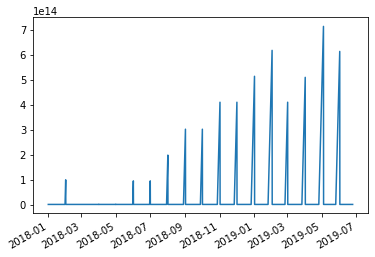

In [87]:
timme_df = time_steps(clean_df)

In [89]:
timme_df[timme_df.time_delta > dt.timedelta(minutes = 10)]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,time_delta
2018-02-01 03:20:00,0.470467,0.614612,0.144145,2018-02-01 04:00:00+01:00,0.0,13.055804,656.781130,99372.96250,1.076438,0.003659,...,54.056635,66.703767,11.334257,6.159610,11.247049,16.504561,2018-01-31 18:00:00+00:00,70.030037,-37.518097,1 days 03:30:00
2018-03-31 22:00:00,0.069826,0.075014,0.005188,2018-04-01 00:00:00+02:00,0.0,8.546135,498.243667,100331.73125,0.482458,0.003673,...,223.084107,237.459306,6.959309,3.678809,6.747571,11.209571,2018-03-31 12:00:00+00:00,335.011475,-32.400940,0 days 00:20:00
2018-04-30 22:00:00,0.163683,0.192346,0.028663,2018-05-01 00:00:00+02:00,7.5,9.281732,224.865671,100035.90000,2.209233,0.005903,...,95.734538,21.284337,8.289386,3.730394,8.118580,14.208779,2018-04-30 12:00:00+00:00,339.876373,-22.471024,0 days 00:20:00
2018-06-01 02:10:00,0.127864,0.146984,0.019120,2018-06-01 04:00:00+02:00,0.0,7.192271,169.538750,101599.78125,1.918500,0.008660,...,267.815913,314.118100,7.105977,3.314000,6.899839,6.156615,2018-05-31 18:00:00+00:00,37.581707,-9.007782,1 days 02:20:00
2018-07-01 02:10:00,0.052906,0.068404,0.015498,2018-07-01 04:00:00+02:00,0.0,3.902580,71.605608,102206.60000,3.120614,0.006845,...,308.735580,307.905307,5.560496,2.467568,5.515304,4.467685,2018-06-30 18:00:00+00:00,35.783306,-8.196304,1 days 02:20:00
2018-08-01 06:50:00,0.001015,0.002272,0.001257,2018-08-01 08:00:00+02:00,198.0,3.008264,260.058220,102080.63750,-0.452029,0.010370,...,141.388874,91.763758,2.741756,1.925532,2.768492,4.222563,2018-08-01 00:00:00+00:00,84.547691,19.583670,2 days 07:00:00
2018-09-01 11:40:00,0.024328,0.029078,0.004750,2018-09-01 13:00:00+02:00,680.0,3.393276,1094.583081,102616.02500,-1.413082,0.007062,...,148.850382,149.585834,3.520197,2.935550,3.469694,3.757055,2018-09-01 00:00:00+00:00,172.131439,47.644485,3 days 11:50:00
2018-10-01 11:40:00,0.211380,0.221672,0.010292,2018-10-01 13:00:00+02:00,400.0,8.600000,1171.137249,101299.85625,-0.750265,0.005723,...,130.520918,133.300833,8.795283,6.404040,8.675665,10.627143,2018-10-01 00:00:00+00:00,176.638840,36.430210,3 days 11:50:00
2018-11-01 17:40:00,0.070643,0.075330,0.004687,2018-11-01 18:00:00+01:00,0.0,6.660860,217.007751,100957.87500,1.327958,0.006109,...,323.810616,266.085509,6.199340,2.774504,6.082159,7.098012,2018-11-01 06:00:00+00:00,260.382812,-10.220027,4 days 17:50:00
2018-12-01 17:40:00,0.264917,0.272615,0.007698,2018-12-01 18:00:00+01:00,17.5,10.856519,529.806914,100908.99375,0.779986,0.005513,...,15.067707,41.172480,8.460782,4.335163,8.266468,13.404292,2018-12-01 06:00:00+00:00,254.357437,-15.212495,4 days 17:50:00


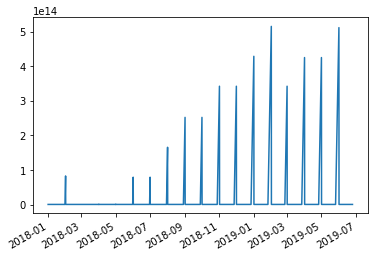

In [103]:
dummy_df = time_steps(nrg_df)

In [104]:
dummy_df[dummy_df.time_delta > dt.timedelta(minutes = 10)]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,time_delta
2018-01-31 22:50:00,0.504521,0.628009,0.123488,2018-01-31 23:00:00+01:00,0 days 23:00:00
2018-03-31 22:00:00,0.069826,0.075014,0.005188,2018-04-01 00:00:00+02:00,0 days 00:20:00
2018-04-30 22:00:00,0.163683,0.192346,0.028663,2018-05-01 00:00:00+02:00,0 days 00:20:00
2018-05-31 21:50:00,0.208707,0.240860,0.032153,2018-05-31 23:00:00+02:00,0 days 22:00:00
2018-06-30 21:50:00,0.050557,0.083927,0.033370,2018-06-30 23:00:00+02:00,0 days 22:00:00
2018-07-31 21:50:00,0.051874,0.082755,0.030882,2018-07-31 23:00:00+02:00,1 days 22:00:00
2018-08-31 21:50:00,0.064814,0.094250,0.029436,2018-08-31 23:00:00+02:00,2 days 22:00:00
2018-09-30 21:50:00,0.013319,0.021288,0.007969,2018-09-30 23:00:00+02:00,2 days 22:00:00
2018-10-31 22:50:00,0.226518,0.235331,0.008813,2018-10-31 23:00:00+01:00,3 days 23:00:00
2018-11-30 22:50:00,0.353818,0.397405,0.043587,2018-11-30 23:00:00+01:00,3 days 23:00:00


# EDA

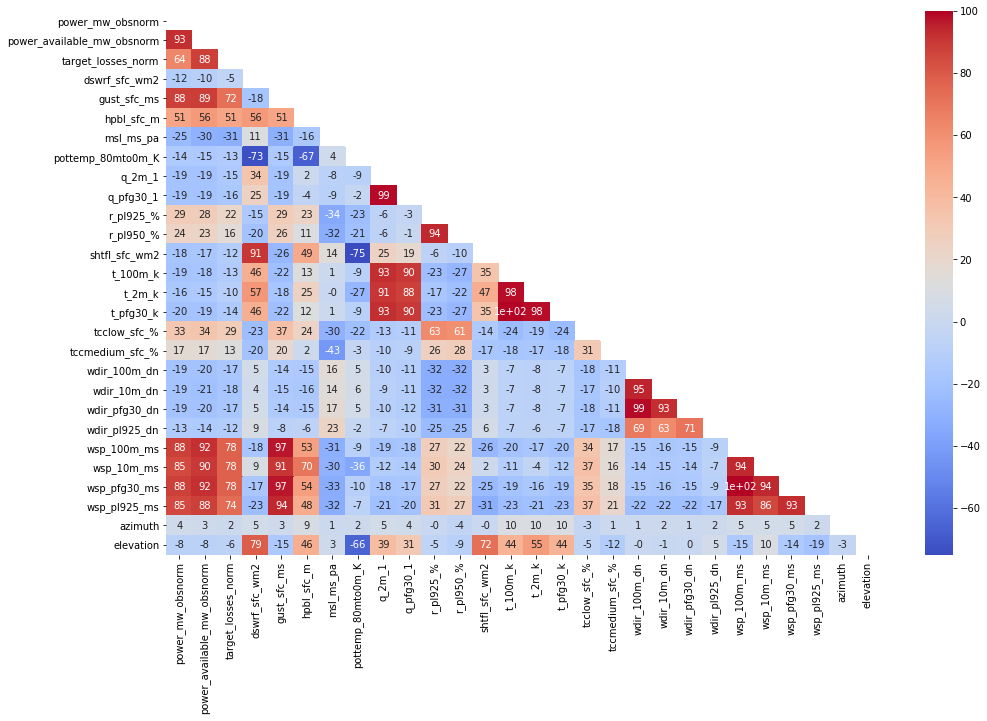

In [55]:
mask = np.triu(clean_df.corr())
plt.figure(figsize = (16,10))
ax = sns.heatmap(round(clean_df.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')

Since it takes quite some time to plot, we will import the results of the pair plot: 
![Pairplot](figures/pairplot.png)

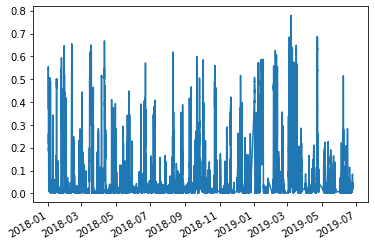

In [56]:
clean_df.target_losses_norm.plot()

In [57]:
loss_above_p = {}
max_loss = max(nrg_df.target_losses_norm)
for p in range(0, 100):
    loss_above_p[p] = nrg_df[nrg_df.target_losses_norm >= max_loss * p /100].shape[0]

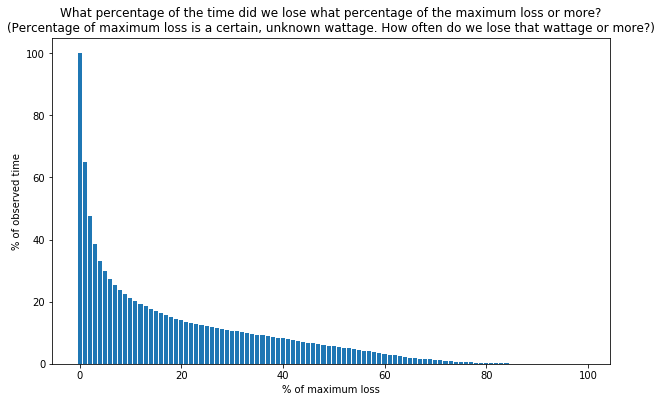

In [58]:
loss_above_p_ratio = {k: v*100/nrg_df.shape[0] for k,v in enumerate(loss_above_p.values())}
plt.figure(figsize = (10,6))
plt.bar(loss_above_p.keys(), loss_above_p_ratio.values())
plt.ylabel('% of observed time')
plt.xlabel('% of maximum loss')
plt.title('What percentage of the time did we lose what percentage of the maximum loss or more?\n(Percentage of maximum loss is a certain, unknown wattage. How often do we lose that wattage or more?)')

plt.savefig('figures/percent_of_time_over_p_of_loss')

In [59]:
loss_p_ratio = dict(enumerate(np.diff(list(loss_above_p_ratio.values()))*(-1)))

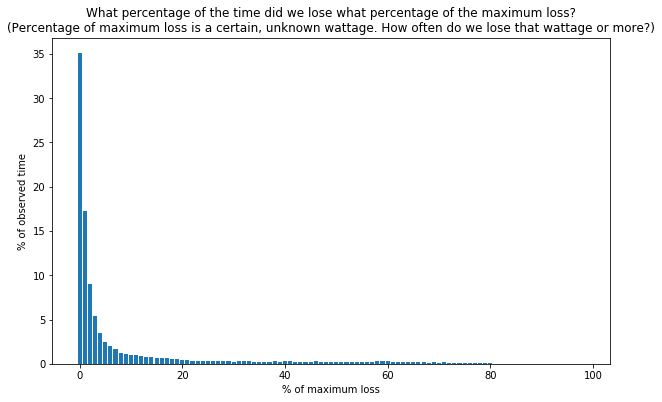

In [60]:
plt.figure(figsize = (10,6))
plt.bar(loss_p_ratio.keys(), loss_p_ratio.values())
plt.ylabel('% of observed time')
plt.xlabel('% of maximum loss')
plt.title('What percentage of the time did we lose what percentage of the maximum loss?\n(Percentage of maximum loss is a certain, unknown wattage. How often do we lose that wattage or more?)')

plt.savefig('figures/percent_of_time_over_p_of_loss')

In [61]:
lpr_log = dict(enumerate(np.log(list(loss_p_ratio.values()))))

C:\Users\thoma\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


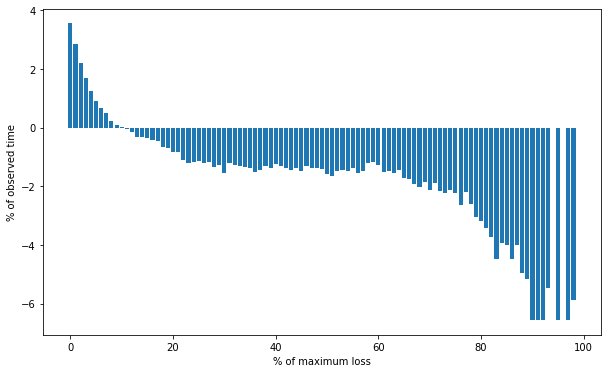

In [62]:
plt.figure(figsize = (10,6))
plt.bar(lpr_log.keys(), lpr_log.values())
plt.ylabel('% of observed time')
plt.xlabel('% of maximum loss')
plt.title('')

plt.savefig('figures/percent_of_time_over_p_of_loss')

In [63]:
lpr_log_log = dict(enumerate(np.log([t for t in lpr_log.values() if t>=1])))

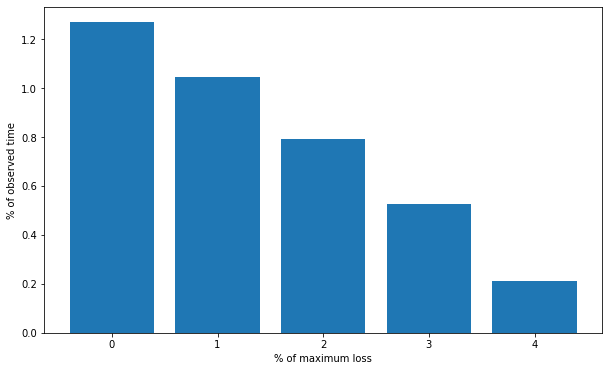

In [64]:
plt.figure(figsize = (10,6))
plt.bar(lpr_log_log.keys(), lpr_log_log.values())
plt.ylabel('% of observed time')
plt.xlabel('% of maximum loss')
plt.title('')

plt.savefig('figures/percent_of_time_over_p_of_loss')


# Prediction

In [128]:
clean_df.target_losses_norm.shape

(68925,)

In [127]:
seasonal_decompose(clean_df.target_losses_norm, model = 'additive', period = '6H')

TypeError: '<' not supported between instances of 'int' and 'str'

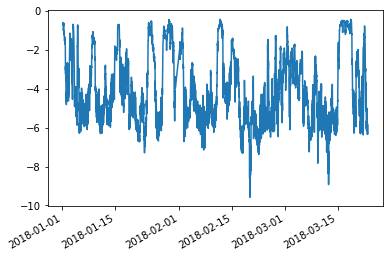

In [72]:
np.log(y_train[0]).plot()

Time to try the arima model.

In [73]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=36).mean()
    rolling_std = timeseries.rolling(window=36).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

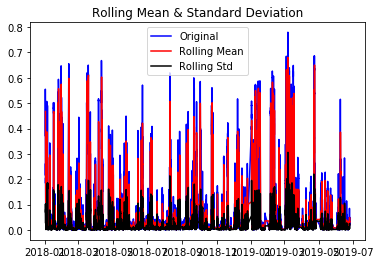

ADF Statistic: -13.82714615555641
p-value: 7.711866960760638e-26
Critical Values:
	1%: -3.4304449645495563
	5%: -2.861581972633967
	10%: -2.5667923406007747


In [74]:
get_stationarity(clean_df.target_losses_norm)

With these values, it is safe to assume, that the time series is stationary. More infos [here](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/ "Article about ADF at Machine Learning Plus").  
We can apply an ARIMA analysis only on stationary time series.

In [105]:
date_list = pd.date_range(clean_df.index[0], clean_df.index[-1], freq='6H')

In [ ]:
X_test, X_train = [], []
y_test, y_train = [], []

for i in range(1,(len(date_list)-1)):
    train_frame = (clean_df.index < date_list[i])
    test_frame = (clean_df.index >= date_list[i-1]) & (clean_df.index < date_list[i])
    X_test.append(clean_df[test_frame])
    X_train.append(clean_df.shift(72)[train_frame])
    y_test.append(clean_df[test_frame])
    y_train.append(clean_df.shift(72)[train_frame])



In [124]:
clean_df[(clean_df.index >= date_list[9+1]) & (clean_df.index < date_list[9+2])]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-03 18:00:00,0.550041,0.612656,0.062616,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,95.818520,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095
2018-01-03 18:10:00,0.578314,0.659056,0.080743,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,95.818520,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095
2018-01-03 18:20:00,0.540305,0.692412,0.152107,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,95.818520,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095
2018-01-03 18:30:00,0.559914,0.715180,0.155266,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,95.818520,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095
2018-01-03 18:40:00,0.586393,0.738188,0.151795,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,95.818520,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095
2018-01-03 18:50:00,0.594558,0.740560,0.146002,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,95.818520,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095
2018-01-03 19:00:00,0.563571,0.724208,0.160637,2018-01-03 20:00:00+01:00,0.0,17.087549,1180.843726,98093.87500,0.480855,0.005258,...,99.836057,103.530155,106.626706,16.030580,9.683557,16.597057,21.529050,2018-01-03 12:00:00+00:00,272.985901,-32.460770
2018-01-03 19:10:00,0.550437,0.714251,0.163814,2018-01-03 20:00:00+01:00,0.0,17.087549,1180.843726,98093.87500,0.480855,0.005258,...,99.836057,103.530155,106.626706,16.030580,9.683557,16.597057,21.529050,2018-01-03 12:00:00+00:00,272.985901,-32.460770
2018-01-03 19:20:00,0.588866,0.739501,0.150635,2018-01-03 20:00:00+01:00,0.0,17.087549,1180.843726,98093.87500,0.480855,0.005258,...,99.836057,103.530155,106.626706,16.030580,9.683557,16.597057,21.529050,2018-01-03 12:00:00+00:00,272.985901,-32.460770
2018-01-03 19:30:00,0.642762,0.787325,0.144563,2018-01-03 20:00:00+01:00,0.0,17.087549,1180.843726,98093.87500,0.480855,0.005258,...,99.836057,103.530155,106.626706,16.030580,9.683557,16.597057,21.529050,2018-01-03 12:00:00+00:00,272.985901,-32.460770


In [ ]:
model = ARIMA(X_.target_losses_norm, order=order)
results = model.fit(disp=-1)



In [ ]:
def run_arima(df, order=(1,0,1), test):
    model = ARIMA(df.target_losses_norm, order=order)
    results = model.fit(disp=-1)
    
    return 

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


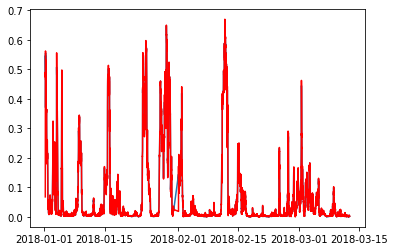

In [75]:
    plt.plot(clean_df[:10000].target_losses_norm)
    plt.plot(results.fittedvalues, color='red')

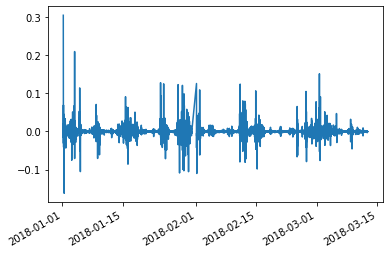

In [76]:
(clean_df[:10000].target_losses_norm - results.fittedvalues).plot()

That works a little to well. But it also does not represent our business case. We have weather predictions for the next six hours. So we have to make a prediction every six hours for six to twelve hours into the future.  
Since I don't want to program the ARIMA algorithm myself, we'll have to feed the model time series that are missing six hours regularly...


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


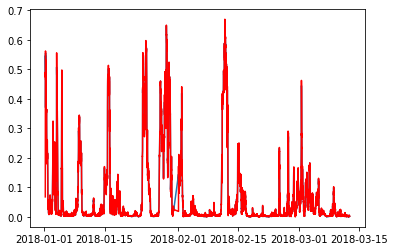

In [77]:
model = ARIMA(clean_df[:10000].target_losses_norm, order=(2,0,2))
results = model.fit(disp=-1)
plt.plot(clean_df[:10000].target_losses_norm)
plt.plot(results.fittedvalues, color='red')

In [78]:
clean_df.head()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-01 06:00:00,0.561235,0.933616,0.372381,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:10:00,0.512618,0.958089,0.445471,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:20:00,0.494356,0.966840,0.472484,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:30:00,0.484470,0.970603,0.486133,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:40:00,0.509116,0.983485,0.474370,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894


In [79]:
len([t for t in clean_df.index if t < clean_df.target_losses_norm.index[2]])

2

In [80]:
clean_df.index.get_loc('2018-01-01 06:10:00	')

1

In [81]:
clean_df.iloc[2]

power_mw_obsnorm                               0.494356
power_available_mw_obsnorm                      0.96684
target_losses_norm                             0.472484
date_by_hour                  2018-01-01 07:00:00+01:00
dswrf_sfc_wm2                                         0
gust_sfc_ms                                      16.777
hpbl_sfc_m                                      1349.93
msl_ms_pa                                       99212.1
pottemp_80mto0m_K                              0.559356
q_2m_1                                         0.005105
q_pfg30_1                                    0.00485236
r_pl925_%                                        89.975
r_pl950_%                                        83.075
shtfl_sfc_wm2                                  -58.4449
t_100m_k                                        280.079
t_2m_k                                          280.496
t_pfg30_k                                       279.812
tcclow_sfc_%                                    

In [82]:
def shift_dataframe(df, t, steps_back=6*24*7, steps_nan=36):
    result = {}
    
    ind = df.index.get_loc(t)
    
    start = ind - steps_back
    if start < 0: 
        start = 0
    
    end = ind - steps_nan
    
    for i in range(start, end):
        result[df.index[i+steps_nan]] = df.iloc[i]
    
    return pd.DataFrame(result)

def slice_dataframe(df, t, steps_back =6*24*7, steps_nan =36):
    ind = df.index.get_loc(t)
    return df.iloc[(ind-steps_back):ind]
    

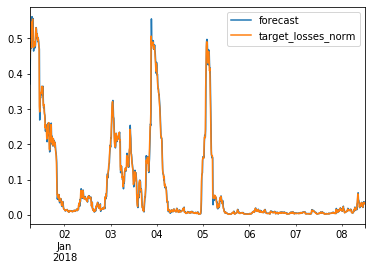

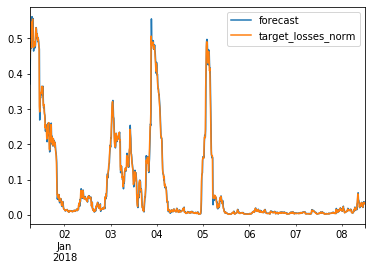

In [83]:
results.plot_predict(1,(6*24*7 + 6*6))

In [84]:
len(clean_df.index)/(6*6)

1914.5833333333333

In [85]:
clean_df['2018-01-30 23:00':'2018-02-01 12:00']

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-30 23:00:00,0.354541,0.388870,0.034329,2018-01-31 00:00:00+01:00,0.0,9.901296,378.633667,101810.62500,0.943696,0.004210,...,28.760355,35.742373,56.584237,8.225162,4.406059,7.992500,11.976190,2018-01-30 12:00:00+00:00,345.808594,-56.303188
2018-01-30 23:10:00,0.321884,0.345163,0.023279,2018-01-31 00:00:00+01:00,0.0,9.901296,378.633667,101810.62500,0.943696,0.004210,...,28.760355,35.742373,56.584237,8.225162,4.406059,7.992500,11.976190,2018-01-30 12:00:00+00:00,345.808594,-56.303188
2018-01-30 23:20:00,0.304780,0.329136,0.024356,2018-01-31 00:00:00+01:00,0.0,9.901296,378.633667,101810.62500,0.943696,0.004210,...,28.760355,35.742373,56.584237,8.225162,4.406059,7.992500,11.976190,2018-01-30 12:00:00+00:00,345.808594,-56.303188
2018-01-30 23:30:00,0.291671,0.316900,0.025228,2018-01-31 00:00:00+01:00,0.0,9.901296,378.633667,101810.62500,0.943696,0.004210,...,28.760355,35.742373,56.584237,8.225162,4.406059,7.992500,11.976190,2018-01-30 12:00:00+00:00,345.808594,-56.303188
2018-01-30 23:40:00,0.305124,0.330091,0.024968,2018-01-31 00:00:00+01:00,0.0,9.901296,378.633667,101810.62500,0.943696,0.004210,...,28.760355,35.742373,56.584237,8.225162,4.406059,7.992500,11.976190,2018-01-30 12:00:00+00:00,345.808594,-56.303188
2018-01-30 23:50:00,0.285141,0.304536,0.019395,2018-01-31 00:00:00+01:00,0.0,9.901296,378.633667,101810.62500,0.943696,0.004210,...,28.760355,35.742373,56.584237,8.225162,4.406059,7.992500,11.976190,2018-01-30 12:00:00+00:00,345.808594,-56.303188
2018-02-01 03:20:00,0.470467,0.614612,0.144145,2018-02-01 04:00:00+01:00,0.0,13.055804,656.781130,99372.96250,1.076438,0.003659,...,47.980006,54.056635,66.703767,11.334257,6.159610,11.247049,16.504561,2018-01-31 18:00:00+00:00,70.030037,-37.518097
2018-02-01 03:30:00,0.465623,0.594261,0.128638,2018-02-01 04:00:00+01:00,0.0,13.055804,656.781130,99372.96250,1.076438,0.003659,...,47.980006,54.056635,66.703767,11.334257,6.159610,11.247049,16.504561,2018-01-31 18:00:00+00:00,70.030037,-37.518097
2018-02-01 03:40:00,0.483067,0.618176,0.135108,2018-02-01 04:00:00+01:00,0.0,13.055804,656.781130,99372.96250,1.076438,0.003659,...,47.980006,54.056635,66.703767,11.334257,6.159610,11.247049,16.504561,2018-01-31 18:00:00+00:00,70.030037,-37.518097
2018-02-01 03:50:00,0.513379,0.643940,0.130561,2018-02-01 04:00:00+01:00,0.0,13.055804,656.781130,99372.96250,1.076438,0.003659,...,47.980006,54.056635,66.703767,11.334257,6.159610,11.247049,16.504561,2018-01-31 18:00:00+00:00,70.030037,-37.518097


In [ ]:
#decomposition = seasonal_decompose(clean_df.target_losses_norm) 
model = ARIMA(clean_df.target_losses_norm, exog = clean_df[wthr_columns], order=(2,0,2))
results = model.fit(disp=-1)
plt.plot(clean_df[:10000].target_losses_norm)
plt.plot(results.fittedvalues, color='red')